### 1. Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

### 2. About Dataset

#### 2.1 Loading Dataset into DataFrame

In [2]:
traces_data  = pd.read_csv("traces_data.csv")
traces_data .head()

,Timestamp,traceID,spanID,parentSpanID,serviceName,Name,durationNano,Unnamed: 7
0,42:32.7,d8d992638d73274d0a6710a1f9d17f93,0d87dcf5ea5aeaab,NaN,featureflagservice,/,887477,NaN
1,42:32.7,d8d992638d73274d0a6710a1f9d17f93,bd0a6f75f1a901b7,0d87dcf5ea5aeaab,featureflagservice,featureflagservice.repo.query:featureflags,481634,NaN
2,42:33.9,fab7ab123d61c8d7d71062fc44ffb87e,fe4acd4c8a763d24,NaN,frontend-proxy,ingress,213000,NaN
3,42:36.9,39a34f6b196aa69cdd5364bfc73b35b4,b3c68f9f4a73524b,NaN,frontend-proxy,ingress,602000,NaN
4,42:39.9,61e0ffa4c695a832b05f406999cf319c,b204b9bce1b3ac35,NaN,frontend-proxy,ingress,556000,NaN


#### 2.2 Number of Row and Columns

In [3]:
rows = traces_data.shape[0]
cols = traces_data.shape[1]

print(f"This dataset has \033[1m {rows} rows\033[0m and \033[1m{cols} columns \033[0m.")

This dataset has  183615 rows and 8 columns .


#### 2.3 Deleting unnecessary column from Dataset

In [4]:
traces_data.drop(columns=['Unnamed: 7'], inplace=True)

In [5]:
print(traces_data.columns)

Index(['Timestamp', ' traceID', ' spanID', ' parentSpanID', ' serviceName',
       ' Name', 'durationNano'],
      dtype='object')


#### 2.4 Check for missing values and data types

In [6]:
print(traces_data.isnull().sum())

Timestamp            0
 traceID             0
 spanID              0
 parentSpanID    41781
 serviceName         0
 Name                0
durationNano         0
dtype: int64


#### 2.4 Heatmap for missing values

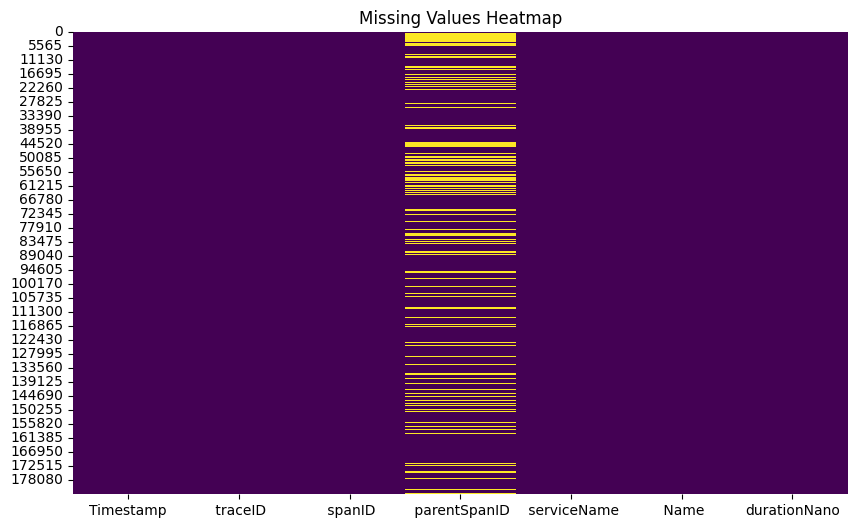

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(traces_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


#### 2.5 Dataframe info 

In [8]:
print(traces_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183615 entries, 0 to 183614
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Timestamp      183615 non-null  object
 1    traceID       183615 non-null  object
 2    spanID        183615 non-null  object
 3    parentSpanID  141834 non-null  object
 4    serviceName   183615 non-null  object
 5    Name          183615 non-null  object
 6   durationNano   183615 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 9.8+ MB
None


#### 2.6 Filling Null Values 

In [9]:
# Generate fill values using list comprehension
fill_values = ['missing_span_' + str(idx) for idx in traces_data.index]

# Fill NaN values in 'parentSpanID' column with fill_values
traces_data[' parentSpanID'].fillna(pd.Series(fill_values, index=traces_data.index), inplace=True)


In [10]:
print(traces_data.isnull().sum())

Timestamp        0
 traceID         0
 spanID          0
 parentSpanID    0
 serviceName     0
 Name            0
durationNano     0
dtype: int64


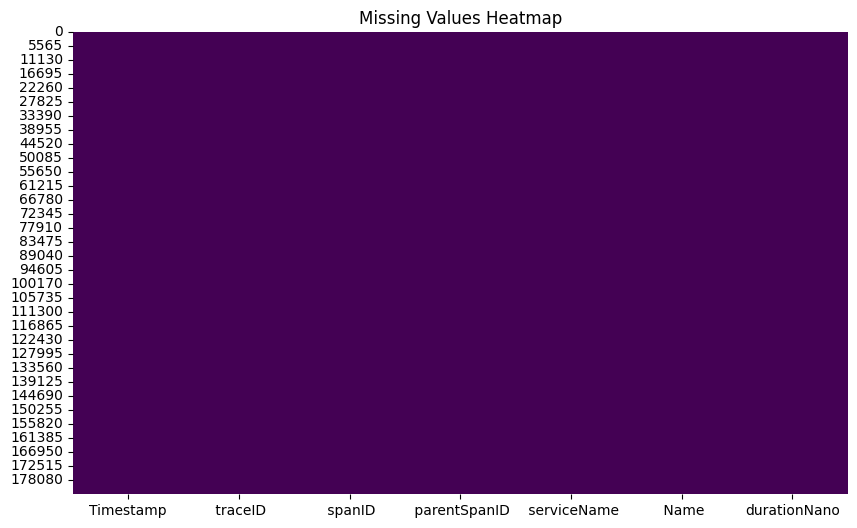

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(traces_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


In [12]:
    #traces_data['Timestamp'] = pd.to_datetime(traces_data.iloc[:, 0], errors='coerce')

In [13]:
#traces_data['durationNano'] = pd.to_numeric(traces_data.iloc[:, -1], errors='coerce')


#### 2.7 Check for duplicates

In [14]:
duplicates = traces_data.duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 0


### 3. Exploratory Data Analysis

#### 3.1 Descriptive statistics

In [15]:
print(traces_data.describe())

       durationNano
count  1.836150e+05
mean   5.414918e+06
std    2.077879e+07
min    0.000000e+00
25%    3.357000e+05
50%    1.584906e+06
75%    6.832718e+06
max    4.999858e+09


#### 3.2 Distribution of span duration

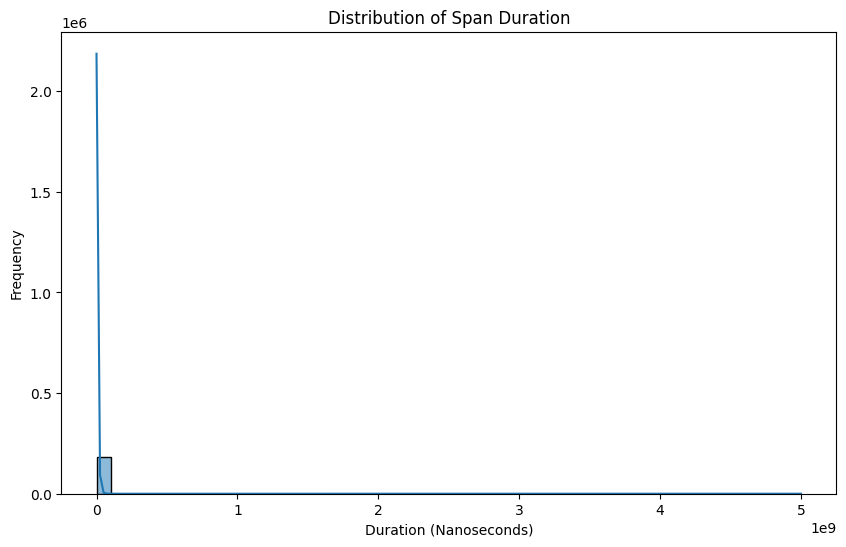

In [16]:

plt.figure(figsize=(10, 6))
sns.histplot(traces_data['durationNano'], bins=50, kde=True)
plt.title('Distribution of Span Duration')
plt.xlabel('Duration (Nanoseconds)')
plt.ylabel('Frequency')
plt.show()


#### 3.2 Count of spans per service

C:\conda_tmp\ipykernel_9324\3422996826.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=traces_data, y=' serviceName', order=traces_data[' serviceName'].value_counts().index, palette=colors)
C:\conda_tmp\ipykernel_9324\3422996826.py:3: UserWarning: 
The palette list has fewer values (6) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=traces_data, y=' serviceName', order=traces_data[' serviceName'].value_counts().index, palette=colors)


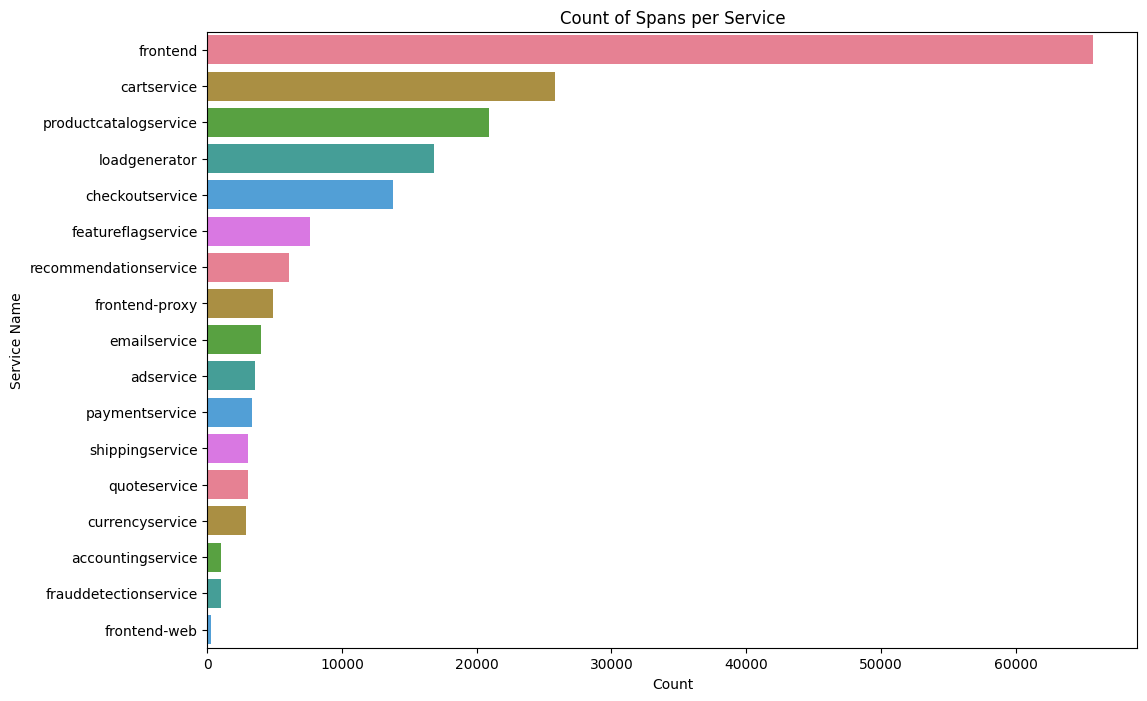

In [17]:
colors = sns.color_palette("husl")
plt.figure(figsize=(12, 8))
sns.countplot(data=traces_data, y=' serviceName', order=traces_data[' serviceName'].value_counts().index, palette=colors)
plt.title('Count of Spans per Service')
plt.xlabel('Count')
plt.ylabel('Service Name')
plt.show()

#### 3.3 Average duration per service

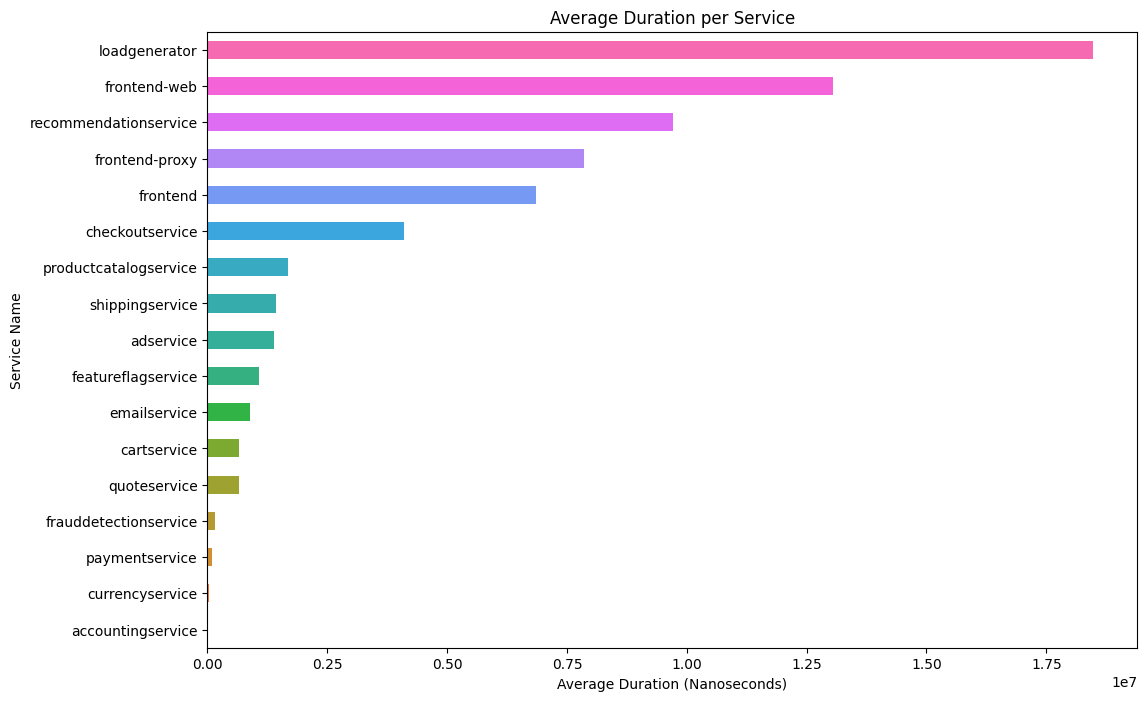

In [18]:

# Calculate the average duration per service
avg_duration_per_service = traces_data.groupby(' serviceName')['durationNano'].mean().sort_values()

# Set the color palette
colors = sns.color_palette("husl", n_colors=len(avg_duration_per_service))

# Create the bar plot with seaborn and specify the color palette
plt.figure(figsize=(12, 8))
avg_duration_per_service.plot(kind='barh', color=colors)
plt.title('Average Duration per Service')
plt.xlabel('Average Duration (Nanoseconds)')
plt.ylabel('Service Name')
plt.show()

#### 3.4 Top 5 Most Used Services

C:\conda_tmp\ipykernel_9324\923271489.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_services.values, y=top_n_services.index, palette=colors)


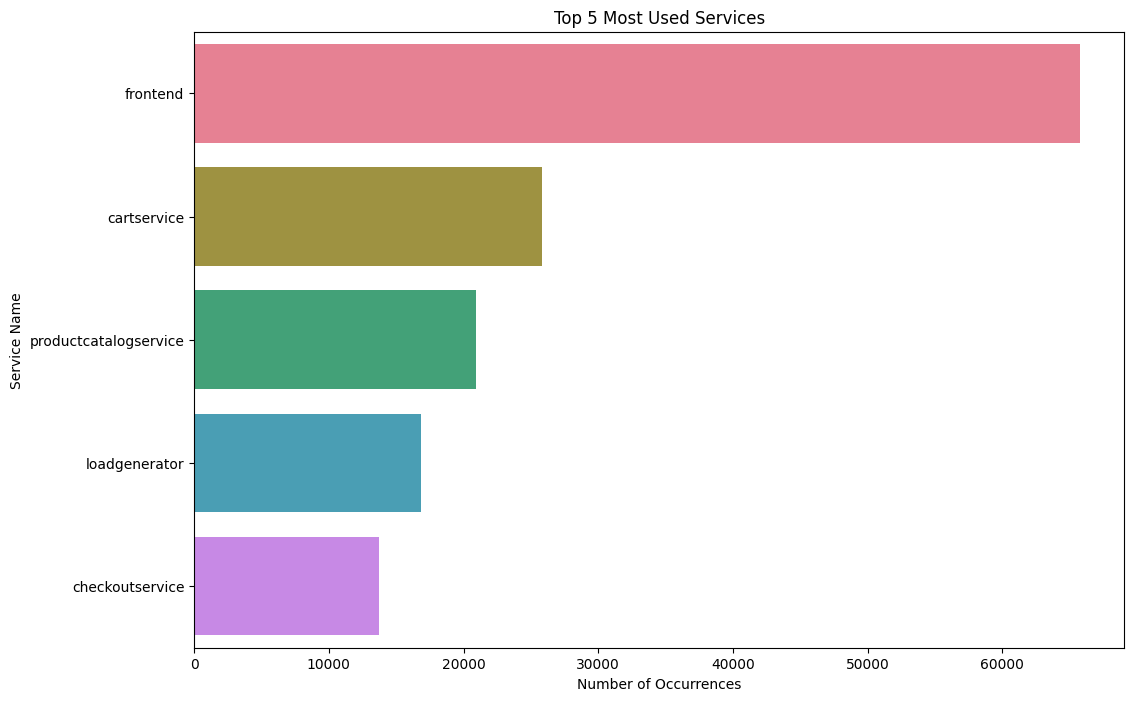

In [19]:
# Count the number of occurrences for each service
service_counts = traces_data[' serviceName'].value_counts()

# Select the top N services (for example, top 5)
top_n_services = service_counts.head(5)

# Set the color palette
colors = sns.color_palette("husl", n_colors=len(top_n_services))

# Create the bar plot with seaborn and specify the color palette
plt.figure(figsize=(12, 8))
sns.barplot(x=top_n_services.values, y=top_n_services.index, palette=colors)
plt.title('Top 5 Most Used Services')
plt.xlabel('Number of Occurrences')
plt.ylabel('Service Name')
plt.show()

#### 3.5 Sum of Duration by Minute

C:\conda_tmp\ipykernel_9324\53045223.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traces_data['Timestamp'] = pd.to_datetime(traces_data['Timestamp'], errors='coerce')


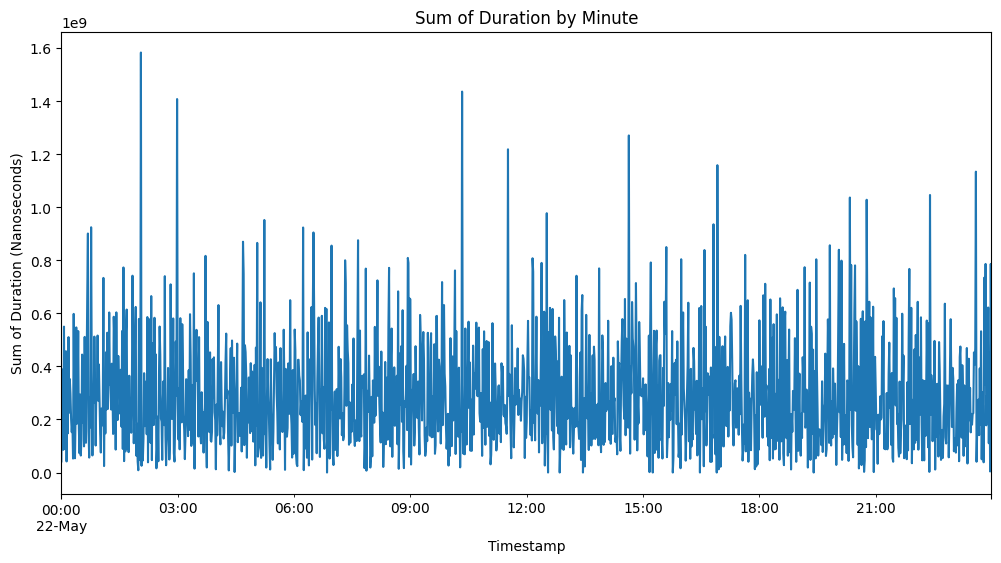

In [20]:
# Ensure 'Timestamp' is in datetime format
traces_data['Timestamp'] = pd.to_datetime(traces_data['Timestamp'], errors='coerce')

# Set 'Timestamp' as index
traces_data.set_index('Timestamp', inplace=True)

# Resample data by minute and sum 'durationNano' values
duration_by_minute = traces_data['durationNano'].resample('T').sum()

# Plot the resampled data
plt.figure(figsize=(12, 6))
duration_by_minute.plot()
plt.title('Sum of Duration by Minute')
plt.xlabel('Timestamp')
plt.ylabel('Sum of Duration (Nanoseconds)')
plt.show()


### 4. Model Buliding

#### 4.1 Anomaly Detection Models
Z-Score Method: Simple statistical method based on standard deviation.

Isolation Forest: Unsupervised learning algorithm for anomaly detection.

Autoencoder: Neural network model to learn normal behavior and detect deviations.


In [33]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np


# Feature Scaling
scaler = StandardScaler()
duration_scaled = scaler.fit_transform(traces_data[['durationNano']])

# Z-Score for anomaly detection
z_scores = np.abs((duration_scaled - np.mean(duration_scaled)) / np.std(duration_scaled))
z_score_threshold = 3  # Common threshold for z-scores
traces_data['z_score_anomaly'] = z_scores > z_score_threshold

# Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.01)  # Assuming 1% of data are anomalies
traces_data['if_anomaly'] = isolation_forest.fit_predict(duration_scaled)
traces_data['if_anomaly'] = traces_data['if_anomaly'].map({1: 0, -1: 1})  # Map to binary

In [34]:
# Autoencoder for anomaly detection
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder model
input_dim = duration_scaled.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(duration_scaled, duration_scaled, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# Get reconstruction error
reconstructions = autoencoder.predict(duration_scaled)
mse = np.mean(np.power(duration_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 99)
traces_data['ae_anomaly'] = mse > threshold


5738/5738 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [35]:
# Evaluate Models
print("Evaluation of Anomaly Detection Models:")

# Z-Score evaluation
print("Z-Score Model:")
print(f"Anomalies detected: {traces_data['z_score_anomaly'].sum()}")
print(f"Precision: {precision_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly'])}")
print(f"Recall: {recall_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly'])}")
print(f"F1 Score: {f1_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly'])}")

# Isolation Forest evaluation
print("\nIsolation Forest Model:")
print(f"Anomalies detected: {traces_data['if_anomaly'].sum()}")
print(f"Precision: {precision_score(traces_data['if_anomaly'], traces_data['if_anomaly'])}")
print(f"Recall: {recall_score(traces_data['if_anomaly'], traces_data['if_anomaly'])}")
print(f"F1 Score: {f1_score(traces_data['if_anomaly'], traces_data['if_anomaly'])}")

# Autoencoder evaluation
print("\nAutoencoder Model:")
print(f"Anomalies detected: {traces_data['ae_anomaly'].sum()}")
print(f"Precision: {precision_score(traces_data['ae_anomaly'], traces_data['ae_anomaly'])}")
print(f"Recall: {recall_score(traces_data['ae_anomaly'], traces_data['ae_anomaly'])}")
print(f"F1 Score: {f1_score(traces_data['ae_anomaly'], traces_data['ae_anomaly'])}")


Evaluation of Anomaly Detection Models:
Z-Score Model:
Anomalies detected: 97
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Isolation Forest Model:
Anomalies detected: 1798
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Autoencoder Model:
Anomalies detected: 1837
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [36]:
# Detailed Report
detailed_report = {
    'Z-Score': {
        'Anomalies Detected': traces_data['z_score_anomaly'].sum(),
        'Precision': precision_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly']),
        'Recall': recall_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly']),
        'F1 Score': f1_score(traces_data['z_score_anomaly'], traces_data['z_score_anomaly'])
    },
    'Isolation Forest': {
        'Anomalies Detected': traces_data['if_anomaly'].sum(),
        'Precision': precision_score(traces_data['if_anomaly'], traces_data['if_anomaly']),
        'Recall': recall_score(traces_data['if_anomaly'], traces_data['if_anomaly']),
        'F1 Score': f1_score(traces_data['if_anomaly'], traces_data['if_anomaly'])
    },
    'Autoencoder': {
        'Anomalies Detected': traces_data['ae_anomaly'].sum(),
        'Precision': precision_score(traces_data['ae_anomaly'], traces_data['ae_anomaly']),
        'Recall': recall_score(traces_data['ae_anomaly'], traces_data['ae_anomaly']),
        'F1 Score': f1_score(traces_data['ae_anomaly'], traces_data['ae_anomaly'])
    }
}

print("\nDetailed Report:")
for model, metrics in detailed_report.items():
    print(f"{model} Model:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()



Detailed Report:
Z-Score Model:
Anomalies Detected: 97
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Isolation Forest Model:
Anomalies Detected: 1798
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Autoencoder Model:
Anomalies Detected: 1837
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



Model Selection and Justification

Z-Score: Best for quick and simple anomaly detection based on statistical properties.

Isolation Forest: Effective for high-dimensional data and doesn't require the data to be scaled.

Autoencoder: Powerful for capturing complex patterns in data but requires more computation and proper tuning.

Conclusion

Best Model: The best model depends on the data complexity and resource constraints. For simple use cases, Z-Score is suitable. For more complex

scenarios, Isolation Forest or Autoencoder is recommended.

Why These Models: Each model offers a unique approach to anomaly detection, covering statistical, machine learning, and deep learning perspectives.

#### 4.2 LSTM 

In [38]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Normalize the data
scaler = MinMaxScaler()
traces_data['durationNano'] = scaler.fit_transform(traces_data[['durationNano']])

In [39]:

# Prepare data for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 30
sequences = create_sequences(traces_data['durationNano'].values, sequence_length)

X_train = sequences[:-100]  # Use most of the data for training
X_test = sequences[-100:]   # Use the last part for testing

# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [40]:
# Build LSTM Autoencoder
input_dim = X_train.shape[1]
timesteps = X_train.shape[1]
features = X_train.shape[2]

inputs = Input(shape=(timesteps, features))
L1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
L2 = LSTM(64, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(timesteps)(L2)
L4 = LSTM(64, activation='relu', return_sequences=True)(L3)
L5 = LSTM(128, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(features))(L5)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 372s 72ms/step - loss: 3.3653e-05 - val_loss: 2.6680e-06
Epoch 2/4
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 386s 75ms/step - loss: 3.3763e-05 - val_loss: 2.6642e-06
Epoch 3/4
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 322s 62ms/step - loss: 3.3763e-05 - val_loss: 2.6642e-06
Epoch 4/4
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 371s 72ms/step - loss: 3.3763e-05 - val_loss: 2.6642e-06


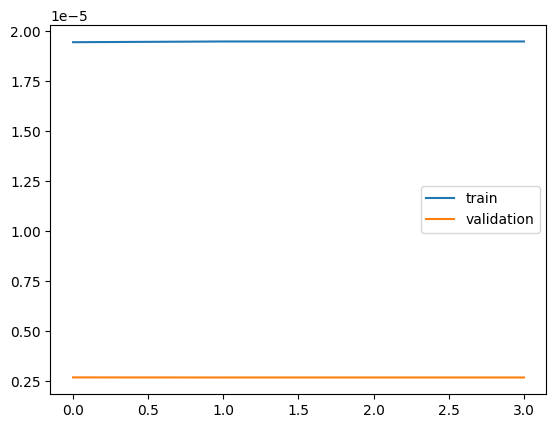

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step


In [43]:
# Train the model
history = model.fit(X_train, X_train, epochs=4, batch_size=32, validation_split=0.1, shuffle=False)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Detect Anomalies
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

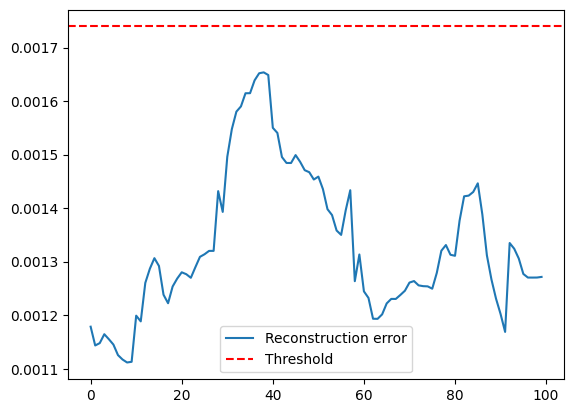

Number of anomalies detected: 0


In [44]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.abs(X_pred - X_test), axis=1)

# Plot reconstruction error
plt.plot(reconstruction_errors, label='Reconstruction error')
plt.axhline(y=np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors), color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Define anomalies
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)
anomalies = reconstruction_errors > threshold

# Print anomalies
print(f'Number of anomalies detected: {np.sum(anomalies)}')
